# Imports

In [1]:
# To install OpenCV: type "conda install opencv" on terminal 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import glob

from skimage.feature import corner_harris, corner_peaks
import cv2
from sklearn import linear_model
from skimage.transform import warp, AffineTransform
from skimage.measure import ransac
from skimage.util.shape import view_as_windows

if not os.path.exists("Q1"):
    os.makedirs("Q1")

# Function Definition

All functions are written in this cell for ease of running codes. Functions are written above their corresponding Tasks again for easy reference

In [2]:
# this function animates a set of images with speed = interval
def animate_tool(frames, interval, repeat, repeat_delay):
    fig = plt.figure()
    im = plt.imshow(frames[0], cmap=plt.get_cmap('gray'), vmin=0, vmax=255, animated=True)
    
    def updatefig(j):
        im.set_array(frames[j])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=range(len(frames)), blit=True,
                                  interval=interval, repeat=repeat, repeat_delay=repeat_delay)
    return ani

# this function performs Corner Harris using openCV and returns an array of corner coordinates
def HarrisCornerCV(frame, numCorners, quality, minDist):
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    #dst = cv2.cornerHarris(gray,2,3,0.04)
    #img[dst>0.01*dst.max()]=[0,0,255]
    #cv2.imshow('dst',img)
    corners = cv2.goodFeaturesToTrack(gray, numCorners, quality, minDist)
    corners = np.int0(corners)
    
    return corners

# this function draws 7 matched feature points across all images, and returns an array of feature points coordinates
def ManualMatching(corners, filename, frame):
    
    # sorting the corners coordinates
    ind = np.lexsort((corners[:,0,0],corners[:,0,1]))    
    sortedCorners = corners[ind]
    
    # 1st Feature Point (white)
    x,y = sortedCorners[0].ravel()
    cv2.circle(frame,(x,y),3,(255,255,255),-1)

    # 2nd Feature Point (black)
    x,y = sortedCorners[1].ravel()
    cv2.circle(frame,(x,y),3,(0,0,0),-1)

    # 3rd Feature Point (red)
    x,y = sortedCorners[2].ravel()
    cv2.circle(frame,(x,y),3,(255,0,0),-1)

    # 4th Feature Point (green)
    x,y = sortedCorners[3].ravel()
    cv2.circle(frame,(x,y),3,(0,128,0),-1)

    # 5th Feature Point (blue)
    x,y = sortedCorners[4].ravel()
    cv2.circle(frame,(x,y),3,(0,0,255),-1)

    # 6th Feature Point (yellow)
    if filename in ["car3", "car4", "car5"]:
        x,y = sortedCorners[6].ravel()
        cv2.circle(frame,(x,y),3,(255,255,0),-1)
    else:
        x,y = sortedCorners[5].ravel()
        cv2.circle(frame,(x,y),3,(255,255,0),-1)

    # 7th Feature Point (pink)
    if filename in ["car1", "car7"]:
        x,y = sortedCorners[9].ravel()
        cv2.circle(frame,(x,y),3,(255,105,180),-1)
    elif filename == "car6":
        x,y = sortedCorners[8].ravel()
        cv2.circle(frame,(x,y),3,(255,105,180),-1)
    else:    
        x,y = sortedCorners[7].ravel()
        cv2.circle(frame,(x,y),3,(255,105,180),-1)
  
    # drawing and saving images
    plt.imshow(frame)
    fn = filename + '_manualMatch.png'
    plt.savefig('Q1/' + fn, dpi=200)
    plt.close()
    
    return sortedCorners

# source: http://stackoverflow.com/questions/12729228/simple-efficient-bilinear-interpolation-of-images-in-numpy-and-python
def bilinear_interpolate(im, x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, im.shape[1]-1)
    x1 = np.clip(x1, 0, im.shape[1]-1)
    y0 = np.clip(y0, 0, im.shape[0]-1)
    y1 = np.clip(y1, 0, im.shape[0]-1)

    Ia = im[y0, x0]
    Ib = im[y1, x0]
    Ic = im[y0, x1]
    Id = im[y1, x1]

    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    return wa*Ia + wb*Ib + wc*Ic + wd*Id

# this function creates an image patch with size LxL centered at coord. 
# NOTE: L must be odd, so that centre of window can be at coord
def CreatePatch(coord, img, L):
    window = view_as_windows(img, (L,L))
    patch = window[coord[1] - L/2, coord[0] - L/2]    
    
    return patch

# this function creates a search window of size LxL centered at refCoord, and returns all feature points in 
# non-stabilized image that are within that window
# NOTE: L must be odd, so that centre of window can be at coord
def SearchFP(refCoord,imgFP,L):
    searchedFP = []
    for imgCoord in imgFP:
        if abs(imgCoord[0]-refCoord[0]) <= L/2 and abs(imgCoord[1]-refCoord[1]) <= L/2:
            searchedFP.append(imgCoord)
            
    return searchedFP

# this function creates template matching of 2 images and output the min value of SSD
def TemplateMatchSSD(img, template):
    method = eval('cv2.TM_SQDIFF')

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    return min_val

def RANSAC(matchedCoord):
    matchedCoord = np.array(matchedCoord)
    src = matchedCoord[:,0]
    dst = matchedCoord[:,1]
    
    # estimate affine transform model using all coordinates
    model = AffineTransform()
    model.estimate(src, dst)

    # robustly estimate affine transform model with RANSAC
    model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
    outliers = inliers == False
    
    return src[inliers], dst[inliers]
            
    

# 1.1 - Viewing Images as Movies

In [25]:
# this function animates a set of images with speed = interval
def animate_tool(frames, interval, repeat, repeat_delay):
    fig = plt.figure()
    im = plt.imshow(frames[0], cmap=plt.get_cmap('gray'), vmin=0, vmax=255, animated=True)
    
    def updatefig(j):
        im.set_array(frames[j])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=range(len(frames)), blit=True,
                                  interval=interval, repeat=repeat, repeat_delay=repeat_delay)
    return ani

/Users/chongyeegan/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


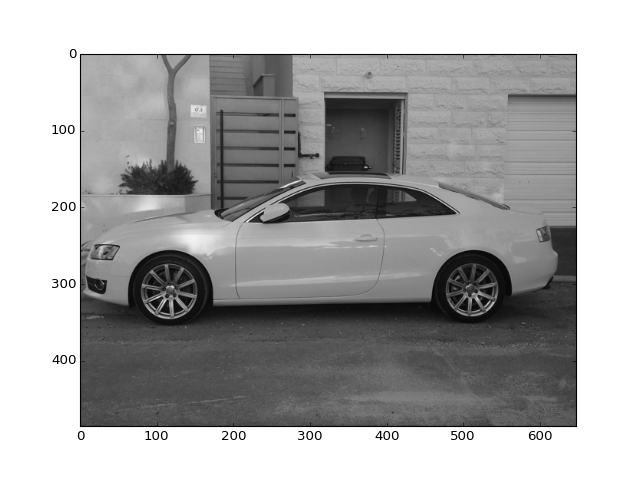

In [3]:
%matplotlib notebook

if __name__ == '__main__':
    path = 'Images/Q1'
    imagelist = []
    
    for filename in glob.glob(os.path.join(path, '*.bmp')): 
        im = plt.imread(filename)
        fn = filename.split('/')[-1].split('.')[0]
        imagelist.append((fn, im))

    #print imagelist
    frames = [i[1] for i in imagelist]
    #print frames
    
    # kick off the animation
    ani = animate_tool(frames, 100, True, 500)

    mins = []

# 1.2 - Harris Corner Detector 

In [6]:
# this function performs Corner Harris using openCV and returns an array of corner coordinates
def HarrisCornerCV(frame, numCorners, quality, minDist):
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    #dst = cv2.cornerHarris(gray,2,3,0.04)
    #img[dst>0.01*dst.max()]=[0,0,255]
    #cv2.imshow('dst',img)
    corners = cv2.goodFeaturesToTrack(gray, numCorners, quality, minDist)
    corners = np.int0(corners)
    
    return corners

In [18]:
%matplotlib inline

if __name__ == '__main__':
    path = 'Images/Q1'
    imagelist = []

    for filename in glob.glob(os.path.join(path, '*.bmp')): 
        im = cv2.imread(filename)
        fn = filename.split('/')[-1].split('.')[0]
        imagelist.append((fn, im))
    
    #OpenCV Method    
    for filename, frame in imagelist:
        corners = HarrisCornerCV(frame, 100, 0.01, 10)
        
        # draw corners on image
        for i in corners:
            x,y = i.ravel()
            cv2.circle(frame,(x,y),3,255,-1)
        
        # save image
        plt.imshow(frame)
        fn = filename + '_corner.png'
        plt.savefig('Q1/' + fn, dpi=200)
        plt.close()
        
        
    ''''
    #Skimage Method
    for filename, frame in imagelist:    
        ch = corner_harris(frame, k=0.04)
        coords = corner_peaks(ch, 1, 0)
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))

        ax.imshow(frame, interpolation='nearest', cmap=plt.cm.gray)
        ax.plot(coords[:, 1], coords[:, 0], '+r', markersize=15)
        plt.axis('off')
        fn = filename + '_corner.png'
        plt.savefig('Q1/' + fn, dpi=200)
        plt.close()
    '''
      

# 1.3 - Manual Matching

In [6]:
# this function draws 7 matched feature points across all images, and returns an array of feature points coordinates
def ManualMatching(corners, filename, frame):
    
    # sorting the corners coordinates
    ind = np.lexsort((corners[:,0,0],corners[:,0,1]))    
    sortedCorners = corners[ind]
    
    # 1st Feature Point (white)
    x,y = sortedCorners[0].ravel()
    cv2.circle(frame,(x,y),3,(255,255,255),-1)

    # 2nd Feature Point (black)
    x,y = sortedCorners[1].ravel()
    cv2.circle(frame,(x,y),3,(0,0,0),-1)

    # 3rd Feature Point (red)
    x,y = sortedCorners[2].ravel()
    cv2.circle(frame,(x,y),3,(255,0,0),-1)

    # 4th Feature Point (green)
    x,y = sortedCorners[3].ravel()
    cv2.circle(frame,(x,y),3,(0,128,0),-1)

    # 5th Feature Point (blue)
    x,y = sortedCorners[4].ravel()
    cv2.circle(frame,(x,y),3,(0,0,255),-1)

    # 6th Feature Point (yellow)
    if filename in ["car3", "car4", "car5"]:
        x,y = sortedCorners[6].ravel()
        cv2.circle(frame,(x,y),3,(255,255,0),-1)
    else:
        x,y = sortedCorners[5].ravel()
        cv2.circle(frame,(x,y),3,(255,255,0),-1)

    # 7th Feature Point (pink)
    if filename in ["car1", "car7"]:
        x,y = sortedCorners[9].ravel()
        cv2.circle(frame,(x,y),3,(255,105,180),-1)
    elif filename == "car6":
        x,y = sortedCorners[8].ravel()
        cv2.circle(frame,(x,y),3,(255,105,180),-1)
    else:    
        x,y = sortedCorners[7].ravel()
        cv2.circle(frame,(x,y),3,(255,105,180),-1)
  
    # drawing and saving images
    plt.imshow(frame)
    fn = filename + '_manualMatch.png'
    plt.savefig('Q1/' + fn, dpi=200)
    plt.close()
    
    return sortedCorners

In [7]:
%matplotlib inline
if __name__ == '__main__':
    path = 'Images/Q1'
    imagelist = []

    # reading images and storing filename
    for filename in glob.glob(os.path.join(path, '*.bmp')): 
        im = cv2.imread(filename)
        fn = filename.split('/')[-1].split('.')[0]
        imagelist.append((fn, im))
    
    #List of feature points. Each row represents an image's 7 feature points respectively. 7 rows (image) in total
    FP = []
    
    #Drawing Select Feature Points for All Images   
    for filename, frame in imagelist:
        corners = HarrisCornerCV(frame, 100, 0.615, 8)
        #corners = HarrisCornerCV(frame, 100, 0.01, 10) #threshold increased to easier match corners  
        sortedCorners = ManualMatching(corners, filename, frame) # create and draw feature points of current image
        
        # Store this image's feature points to the feature points list
        FP.append(sortedCorners)

# 1.4 - Affine Transformation

** NOTE: please run Section 1.3 first to get coordinates of corners**

In [8]:
%matplotlib inline
# Reference - http://stackoverflow.com/questions/20546182/how-to-perform-coordinates-affine-transformation-using-python-part-2
#           - http://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html
#           - http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.lstsq.html

# as all images have different number of feature points, we take the lowest feature points
FPnumber = len(FP[0])
for row in FP:
    if len(row) <= FPnumber:
        FPnumber = len(row)
print "Lowest number of Feature Points in all images is " + str(FPnumber)

# Create Matrix of Reference Feature Points
refPoint = np.vstack(FP[0][:FPnumber])
refPoint = np.vstack([refPoint.T, np.ones(FPnumber)]).T

# Initialise Affine Transform Parameter List (each row represents an affine transform of ref image to Image[n])
A = []

for i in range(1,len(FP)):
    # Create Matrix of Current Image's Feature Points (Xi and Yi)
    imgPoint = np.vstack(FP[i][:FPnumber])
    # Calculating A, where imgPoint = refPoint*A
    A.append(np.linalg.lstsq(refPoint, imgPoint)[0])
    
# Each row in A represents a 3X2 matrix - [[a11,a21],
#                                          [a12,a22],
#                                          [b1,b2]] 

Lowest number of Feature Points in all images is 13


# 1.5 - Stabilization

** NOTE: please run Section 1.4 first to get Affine Transforms (A) **

In [12]:
# source: http://stackoverflow.com/questions/12729228/simple-efficient-bilinear-interpolation-of-images-in-numpy-and-python
def bilinear_interpolate(im, x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, im.shape[1]-1)
    x1 = np.clip(x1, 0, im.shape[1]-1)
    y0 = np.clip(y0, 0, im.shape[0]-1)
    y1 = np.clip(y1, 0, im.shape[0]-1)

    Ia = im[y0, x0]
    Ib = im[y1, x0]
    Ic = im[y0, x1]
    Id = im[y1, x1]

    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    return wa*Ia + wb*Ib + wc*Ic + wd*Id


In [20]:
%matplotlib inline
if __name__ == '__main__':
    path = 'Images/Q1'
    imagelist = []

    for filename in glob.glob(os.path.join(path, '*.bmp')):
        im = cv2.imread(filename)
        fn = filename.split('/')[-1].split('.')[0]
        imagelist.append((fn, im))

    stableds = []
    stableds.append(np.copy(imagelist[0][1]))

    for i in xrange(len(A)):
        A_matrix = A[i]
        stable = np.zeros(imagelist[0][1].shape)
        print imagelist[i+1][0]
        frame = imagelist[i+1][1]

        for (ys, xs) in np.ndindex((stable.shape[0], stable.shape[1])):
            coor = np.array([xs, ys, 1])
            x, y = coor.dot(A_matrix)
            if (x % 1 == 0) and (y % 1 == 0):
                stable[ys, xs] = np.copy(frame[y, x])
            else:
                stable[ys, xs] = np.copy(bilinear_interpolate(frame, x, y).astype('uint8'))
        
        stable = 255-stable #invert image
        stableds.append(stable)
        plt.imshow(stable)
        fn = imagelist[i+1][0] + '_stable1.png'
        plt.savefig('Q1/' + fn, dpi=200)
        plt.close()

get_ipython().magic(u'matplotlib notebook')

print stableds[0][0, 0]
print stableds[1][0, 0]
print stableds[2][0, 0]
print stableds[3][0, 0]
print stableds[4][0, 0]
print stableds[5][0, 0]
print stableds[6][0, 0]


car2
car3
car4
car5
car6
car7
[172 172 172]
[ 91.  91.  91.]
[ 93.  93.  93.]
[ 255.  255.  255.]
[ 88.  88.  88.]
[ 255.  255.  255.]
[ 255.  255.  255.]


<IPython.core.display.Javascript object>


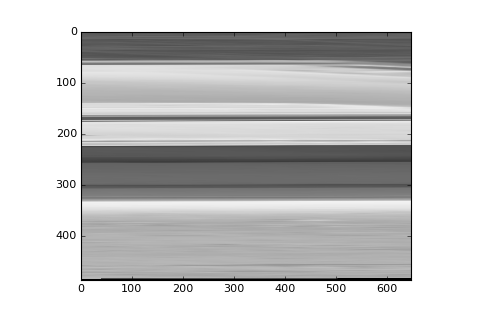

In [11]:
%matplotlib notebook
# kick off the animation
ani = animate_tool(stableds, 100, True, 500)

# 1.6 - Automatic Matching

In [7]:
from skimage.util.shape import view_as_windows

# this function creates an image patch with size LxL centered at coord. 
# NOTE: L must be odd, so that centre of window can be at coord
def CreatePatch(coord, img, L):
    window = view_as_windows(img, (L,L))
    patch = window[coord[1] - L/2, coord[0] - L/2]    
    
    return patch

# this function creates a search window of size LxL centered at refCoord, and returns all feature points in 
# non-stabilized image that are within that window
# NOTE: L must be odd, so that centre of window can be at coord
def SearchFP(refCoord,imgFP,L):
    searchedFP = []
    for imgCoord in imgFP:
        if abs(imgCoord[0]-refCoord[0]) <= L/2 and abs(imgCoord[1]-refCoord[1]) <= L/2:
            searchedFP.append(imgCoord)
            
    return searchedFP

# this function creates template matching of 2 images and output the min value of SSD
def TemplateMatchSSD(img, template):
    method = eval('cv2.TM_SQDIFF')

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    return min_val
            
    

In [3]:
%matplotlib inline

if __name__ == '__main__':
    path = 'Images/Q1'
    imagelist = []

    # reading images and storing filename
    for filename in glob.glob(os.path.join(path, '*.bmp')): 
        im = cv2.imread(filename)
        fn = filename.split('/')[-1].split('.')[0]
        imagelist.append((fn, im))
    
    
    refFP, imgFP, matchedCoordList = [], [], []
    refFilename, refFrame = imagelist[0]
    refGray = cv2.cvtColor(refFrame,cv2.COLOR_BGR2GRAY)
    
    # Creating Feature Points for Reference/Stabilised Image
    corners = HarrisCornerCV(refFrame, 100, 0.01, 10)
    for i in corners:
        x,y = i.ravel()
        refFP.append([x,y])
    
    # Creating array of Matched Feature Points for All Images, and drawing 10 Matched Feature Points in Q1 folder 
    for filename, frame in imagelist[1:]:
        imgGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Creating Feature Points for Non-Stabilised Image
        corners = HarrisCornerCV(frame, 100, 0.01, 10)
        for i in corners:
            x,y = i.ravel()
            imgFP.append([x,y])
    
        matchedCoord = [] # array to store matched feature points
        
        for refCoord in refFP:
            # Finding feature points in non-stabilised image that are within search window
            searchedFP = SearchFP(refCoord, imgFP, 17) #window bigger than min_dist between FP
            if len(searchedFP) == 0:
                continue # if no feature points were found in search window, don't register refCoord to matchedCoord
            else:    
                template = CreatePatch(refCoord, refGray, 2)
                SSD = [] # array to store SSD of searchedPatch vs stabilised image patch
                for searchedCoord in searchedFP:
                    img = CreatePatch(searchedCoord, imgGray,2)
                    min_val = TemplateMatchSSD(img, template)
                    SSD.append(min_val)

                # matching ref FP to with FP in non-stabilised image
                SSD = np.array(SSD)
                idx = np.argmin(SSD)
                matchedCoord.append([refCoord, searchedFP[idx]])
        
        print str(len(matchedCoord)) + " Matched FPs found in " + filename
        matchedCoordList.append(matchedCoord)
                               
        ## Drawing Matched Feature Points
        # 1st Feature Point (white)
        xR,yR = matchedCoord[0][0]
        cv2.circle(refFrame,(xR,yR),3,(255,255,255),-1)
        xI,yI = matchedCoord[0][1]
        cv2.circle(frame,(xI,yI),3,(255,255,255),-1)
        # 2nd Feature Point (black)
        xR,yR = matchedCoord[1][0]
        cv2.circle(refFrame,(xR,yR),3,(0,0,0),-1)
        xI,yI = matchedCoord[1][1]
        cv2.circle(frame,(xI,yI),3,(0,0,0),-1)
        # 3rd Feature Point (red)
        xR,yR = matchedCoord[2][0]
        cv2.circle(refFrame,(xR,yR),3,(255,0,0),-1)
        xI,yI = matchedCoord[2][1]
        cv2.circle(frame,(xI,yI),3,(255,0,0),-1)
        # 4th Feature Point (yellow)
        xR,yR = matchedCoord[3][0]
        cv2.circle(refFrame,(xR,yR),3,(255,255,0),-1)
        xI,yI = matchedCoord[3][1]
        cv2.circle(frame,(xI,yI),3,(255,255,0),-1)
        # 5th Feature Point (blue)
        xR,yR = matchedCoord[4][0]
        cv2.circle(refFrame,(xR,yR),3,(0,0,255),-1)
        xI,yI = matchedCoord[4][1]
        cv2.circle(frame,(xI,yI),3,(0,0,255),-1)
        # 6th Feature Point (green)
        xR,yR = matchedCoord[5][0]
        cv2.circle(refFrame,(xR,yR),3,(0,128,0),-1)
        xI,yI = matchedCoord[5][1]
        cv2.circle(frame,(xI,yI),3,(0,128,0),-1)
        # 7th Feature Point (purple)
        xR,yR = matchedCoord[6][0]
        cv2.circle(refFrame,(xR,yR),3,(128,0,128),-1)
        xI,yI = matchedCoord[6][1]
        cv2.circle(frame,(xI,yI),3,(128,0,128),-1)
        # 8th Feature Point (orange)
        xR,yR = matchedCoord[7][0]
        cv2.circle(refFrame,(xR,yR),3,(255,165,0),-1)
        xI,yI = matchedCoord[7][1]
        cv2.circle(frame,(xI,yI),3,(255,165,0),-1)
        # 9th Feature Point (pink)
        xR,yR = matchedCoord[8][0]
        cv2.circle(refFrame,(xR,yR),3,(255,105,180),-1)
        xI,yI = matchedCoord[8][1]
        cv2.circle(frame,(xI,yI),3,(255,105,180),-1)
        # 10th Feature Point (gray)
        xR,yR = matchedCoord[9][0]
        cv2.circle(refFrame,(xR,yR),3,(128,128,128),-1)
        xI,yI = matchedCoord[9][1]
        cv2.circle(frame,(xI,yI),3,(128,128,128),-1)
        
        plt.imshow(frame)
        fn = filename + '_autoMatch.png'
        plt.savefig('Q1/' + fn, dpi=200)
        plt.close()
        
        plt.imshow(refFrame)
        fn = 'car1_autoMatch.png'
        plt.savefig('Q1/' + fn, dpi=200)
        plt.close()
        
        

94 Matched FPs found in car2
98 Matched FPs found in car3
98 Matched FPs found in car4
99 Matched FPs found in car5
100 Matched FPs found in car6
100 Matched FPs found in car7


# 1.7 - RANSAC

** NOTE: Please Run Task 1.6 first to get matched feature points coordinates **

In [9]:
from sklearn import linear_model
from skimage.transform import warp, AffineTransform
from skimage.measure import ransac

def RANSAC(matchedCoord):
    matchedCoord = np.array(matchedCoord)
    src = matchedCoord[:,0]
    dst = matchedCoord[:,1]
    
    # estimate affine transform model using all coordinates
    model = AffineTransform()
    model.estimate(src, dst)

    # robustly estimate affine transform model with RANSAC
    model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
    outliers = inliers == False
    
    return src[inliers], dst[inliers]

In [4]:
from sklearn import linear_model
from skimage.transform import warp, AffineTransform
from skimage.measure import ransac

A_auto = []

for matchedCoord in matchedCoordList:
    src, dst = RANSAC(matchedCoord)
    refPoint = np.vstack([src.T, np.ones(len(src))]).T
    imgPoint = dst
    
    A_auto.append(np.linalg.lstsq(refPoint, imgPoint)[0])

        # Each row in A represents a 3X2 matrix - [[a11,a21],
        #                                          [a12,a22],
        #                                          [b1,b2]] 

# 1.8 - Stabilization II

** NOTE: Please run Task 1.7 first to get Affine Transforms (A) **

In [5]:
%matplotlib inline

if __name__ == '__main__':
    path = 'Images/Q1'
    imagelist = []

    for filename in glob.glob(os.path.join(path, '*.bmp')):
        im = cv2.imread(filename)
        fn = filename.split('/')[-1].split('.')[0]
        imagelist.append((fn, im))

    stableds = []
    stableds.append(np.copy(imagelist[0][1]))

    for i in xrange(len(A_auto)):
        A_matrix = A_auto[i]
        stable = np.zeros(imagelist[0][1].shape)
        print imagelist[i+1][0]
        frame = imagelist[i+1][1]

        for (ys, xs) in np.ndindex((stable.shape[0], stable.shape[1])):
            coor = np.array([xs, ys, 1])
            x, y = coor.dot(A_matrix)
            #x, y = coor.dot(A_matrix)
            if (x % 1 == 0) and (y % 1 == 0):
                stable[ys, xs] = np.copy(frame[y, x])
            else:
                stable[ys, xs] = np.copy(bilinear_interpolate(frame, x, y).astype('uint8'))
        stable = 255-stable #invert image
        stableds.append(stable)
        plt.imshow(stable)
        fn = imagelist[i+1][0] + '_stable2.png'
        plt.savefig('Q1/' + fn, dpi=200)
        plt.close()

get_ipython().magic(u'matplotlib notebook')


print stableds[0][0, 0]
print stableds[1][0, 0]
print stableds[2][0, 0]
print stableds[3][0, 0]
print stableds[4][0, 0]
print stableds[5][0, 0]
print stableds[6][0, 0]



car2
car3
car4
car5
car6
car7


/Users/chongyeegan/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


'\nprint stableds[0][0, 0]\nprint stableds[1][0, 0]\nprint stableds[2][0, 0]\nprint stableds[3][0, 0]\nprint stableds[4][0, 0]\nprint stableds[5][0, 0]\nprint stableds[6][0, 0]\n'

<IPython.core.display.Javascript object>


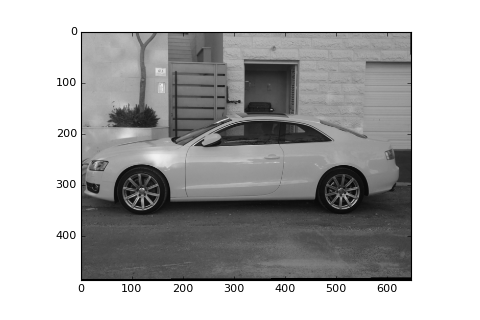

In [7]:
%matplotlib notebook
# kick off the animation
ani = animate_tool(stableds, 100, True, 500)